<h1> Wide and Deep Networks</h1>
Authors: Sam Yao, Rebecca Kuhlman, Michael Amberg

<h2>Data Preparation</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data",
                 names=["Wife's age","Wife's education","Husband's education",
                        "Number of children","Religion","Wife's working?"
                        ,"Husband's occupation","Standard-of-living index","Media exposure", "Contraceptive method used"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Wife's age                 1473 non-null   int64
 1   Wife's education           1473 non-null   int64
 2   Husband's education        1473 non-null   int64
 3   Number of children         1473 non-null   int64
 4   Religion                   1473 non-null   int64
 5   Wife's working?            1473 non-null   int64
 6   Husband's occupation       1473 non-null   int64
 7   Standard-of-living index   1473 non-null   int64
 8   Media exposure             1473 non-null   int64
 9   Contraceptive method used  1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB
None


In [2]:
print(df.describe())

        Wife's age  Wife's education  Husband's education  Number of children  \
count  1473.000000       1473.000000          1473.000000         1473.000000   
mean     32.538357          2.958588             3.429735            3.261371   
std       8.227245          1.014994             0.816349            2.358549   
min      16.000000          1.000000             1.000000            0.000000   
25%      26.000000          2.000000             3.000000            1.000000   
50%      32.000000          3.000000             4.000000            3.000000   
75%      39.000000          4.000000             4.000000            4.000000   
max      49.000000          4.000000             4.000000           16.000000   

          Religion  Wife's working?  Husband's occupation  \
count  1473.000000      1473.000000           1473.000000   
mean      0.850645         0.749491              2.137814   
std       0.356559         0.433453              0.864857   
min       0.000000        

Attribute Information:

   1. Wife's age                     (numerical) - INT
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical) - INT
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
      -What the categories were mapped to is unknown
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use
                                                        2=Long-term
                                                        3=Short-term

In [2]:
#removing Husband's Occupation

df = df.drop(labels="Husband's occupation", axis = 1)

<AxesSubplot:>

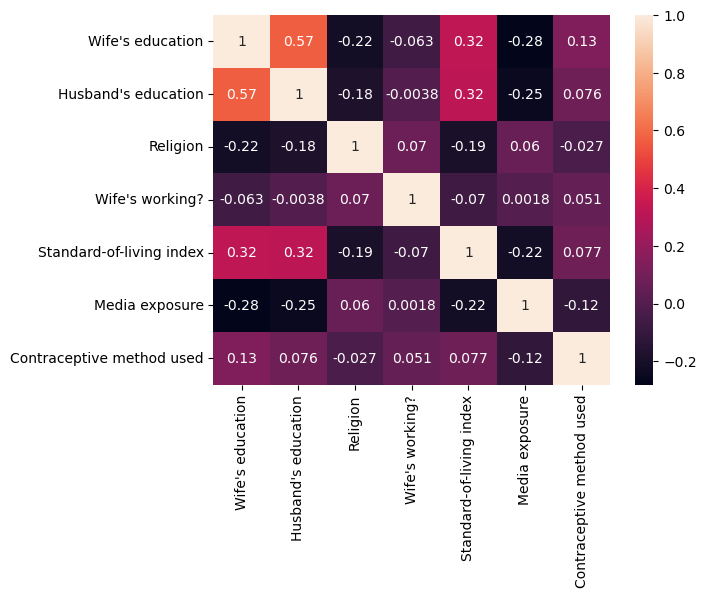

In [4]:
#print heatmap
import seaborn as sns

df_corr = df[["Wife's education",
              "Husband's education",
              "Religion",
              "Wife's working?",
              "Standard-of-living index",
              "Media exposure", 
              "Contraceptive method used"]]
sns.heatmap(df_corr.corr(method="kendall"), annot = True) #Kendall works for categorical data

From this heatmap, we can see an interesting trend. Contraceptive use has a small positive correlation with wife's education, while media exposure has a small negative correlation.

Let's see what a Random Forest Decision Tree estimator has to say.

 1) Wife's age                     0.419224
 2) Religion                       0.251323
 3) Wife's education               0.091610
 4) Standard-of-living index       0.088691
 5) Husband's education            0.067937
 6) Wife's working?                0.036469
 7) Number of children             0.027335
 8) Media exposure                 0.017411


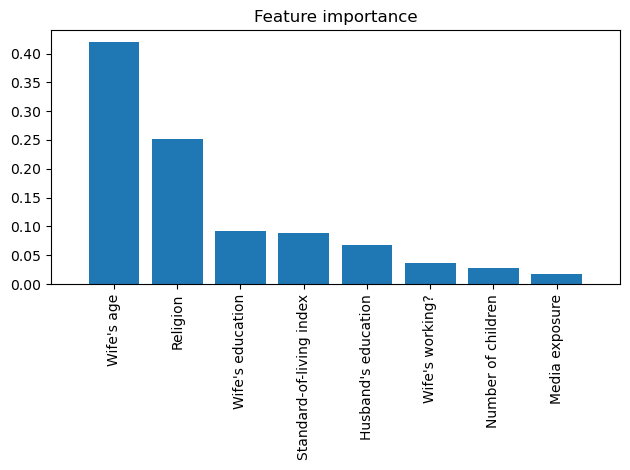

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Code taken from textbook by Raschka
feat_labels = df.columns[:8]
rfc = RandomForestClassifier(n_estimators = 500,
                            random_state = 1)
X = df[["Wife's age","Wife's education",
               "Husband's education", "Religion","Number of children", 
               "Wife's working?","Standard-of-living index",
               "Media exposure"]]
y = df["Contraceptive method used"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]),
            feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
                            

Utilizing the Random Forest method for feature importance (outlined in Raschka et al. on page 134), we can see that the Wife's Age and the Religion will be the most likely to have an impact on training. 

For scaling, we went with min-max scaling. The reason is because the features we want to scale, age and number of children, have a defined 0. For example, it makes no sense to have a negative age or to have borne negative children. Since MinMax scales from 0 to 1, this will be our scaler of choice.

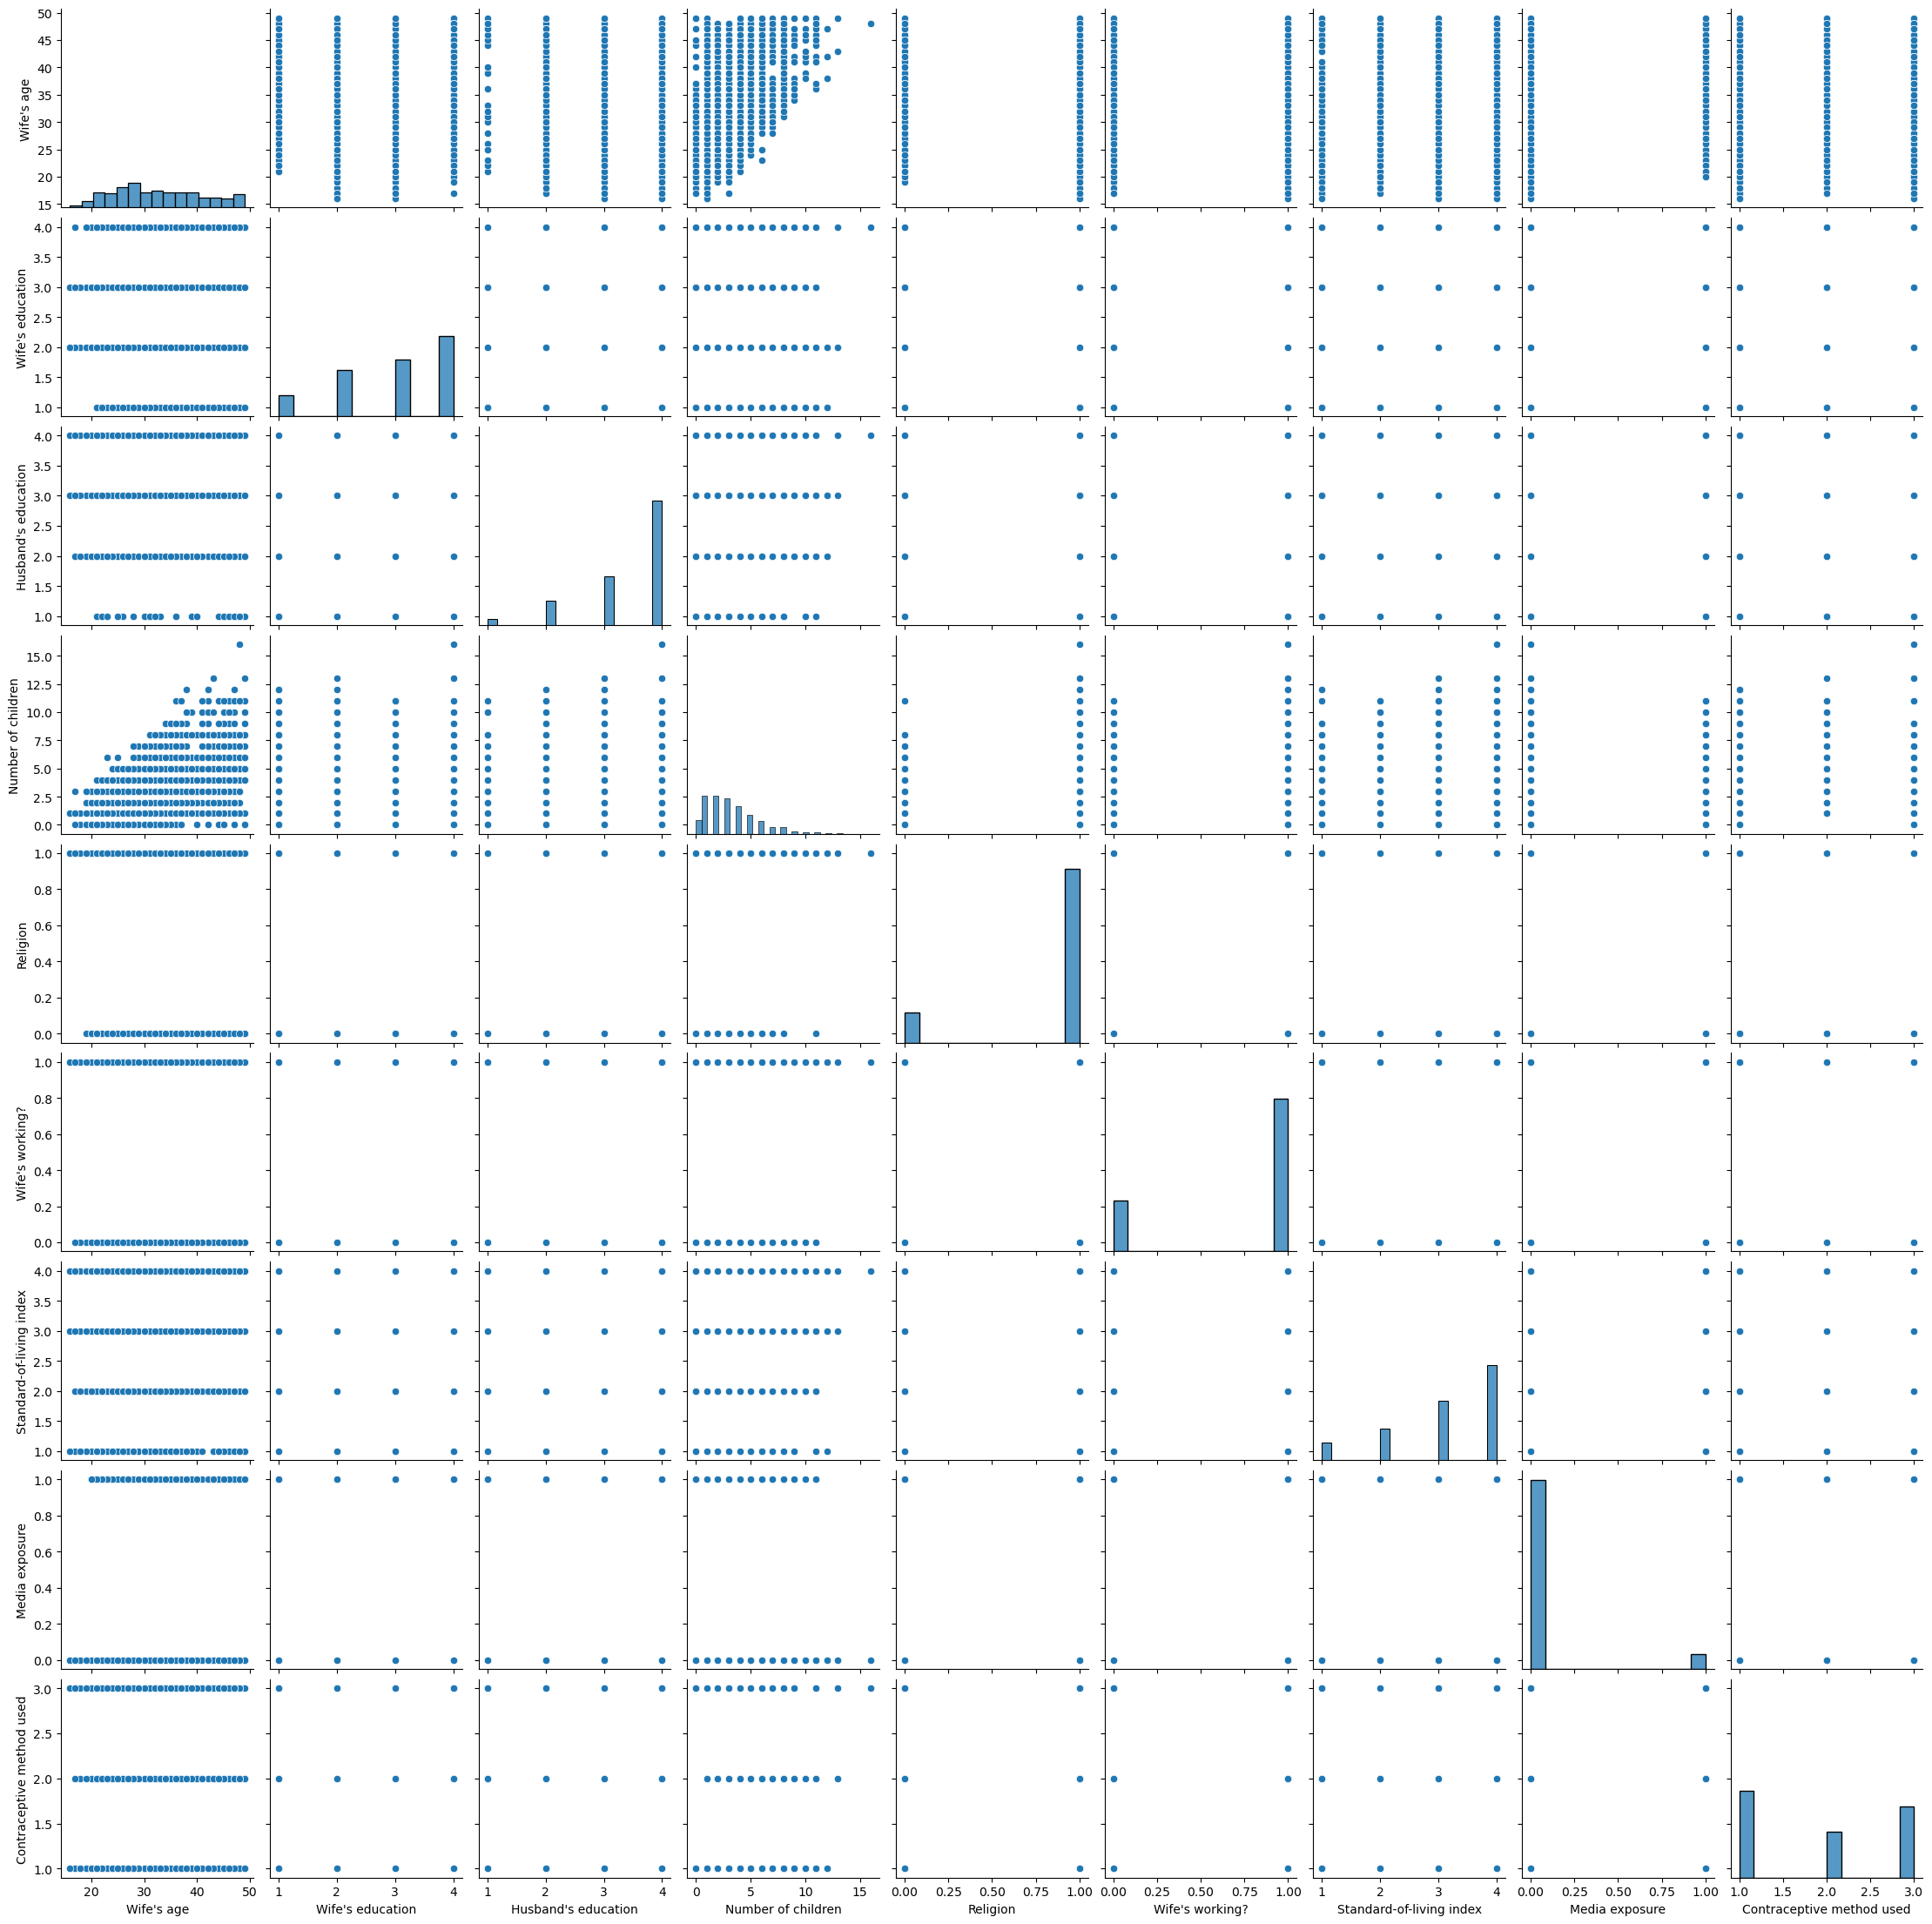

In [4]:
sns.pairplot(df)

<h3>Cross Product Features</h3>
[1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).

Wife working and wife education are related features that could be combined, but there is a lot of nuance between them. For example, education is generally linked to socio-economic class. A wife could have very high education and therefore be working a white collar job, or a wife could be poorly educated and need to work due to needing to bring in money to the household as well. We have a few enough features that is it not needed to cross product features, so due to the nuance in this case, we will leave the features as is.

It may also be worth it to cross the attributes "Wife's Education" with "Husband's Education". There could be some sort of pattern that we could find with patterns involving different combinations of the couple's educational backgrounds.

<h3>Metrics for Algorithm Performance</h3>
[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


The most important feature prediction is no contraceptive use vs contraceptive use. We are using our prediction algorithm to determine which women we are going to give extra contraception information to. Taking contraceptive use as true, a false positive has much higher risk than a false negative. Because of this, we will choose specificity score as our metric. We want to cover all true negatives.

<h3>Dividing into Training and Testing</h3>
[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

Our data is a subset of a census of Indonesian Women, so our split relies on the good practices of whom we got the dataset from. There is slightly more women without contraceptive use than the group using short term and the group using long term. Stratified splits would make sure we are testing of each class, however in this case, a standard shuffled split would work most of the time.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train[["Wife's age", "Number of children"]] = mms.fit_transform(X_train[["Wife's age", "Number of children"]])
X_test[["Wife's age", "Number of children"]] = mms.transform(X_test[["Wife's age", "Number of children"]])

<h2>Modeling (5 points total)</h2>

Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly.

Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). .